In [1]:
import pandas as pd
import geopandas as gpd
import pygeohydro as gh
from pygeohydro import NWIS, NID
from pynhd import NLDI, NHD, WaterData, ZeroMatched
from shapely import ops

- https://doi.org/10.5194/hess-17-3189-2013
- https://doi.org/10.1002/2017WR020871

In [2]:
start = "1990-01-01"
end = "2010-01-01"
texas = gh.helpers.get_us_states("contiguous")
texas = texas[texas.STUSPS == "TX"]

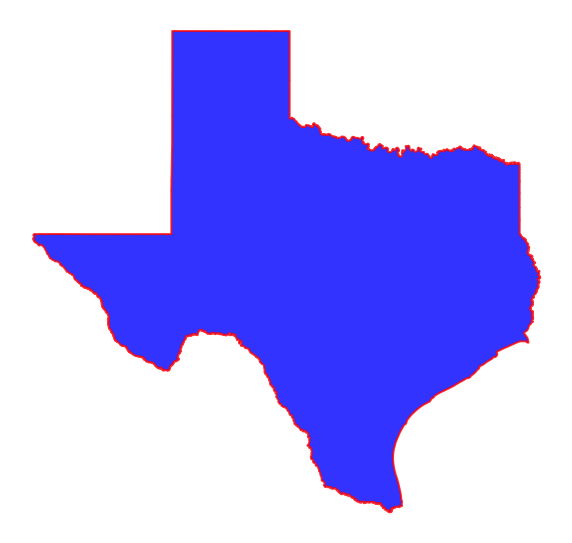

In [3]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
ax.set_axis_off()

In [4]:
nwis = NWIS()
query = {
    "stateCd": "TX",
    "startDt": start,
    "endDt": end,
    "outputDataTypeCd": "dv",  # daily values
    "hasDataTypeCd": "dv",  # daily values
    "parameterCd": "00060",  # discharge
}
sites = nwis.get_info(query)
sites.shape[0]

3459

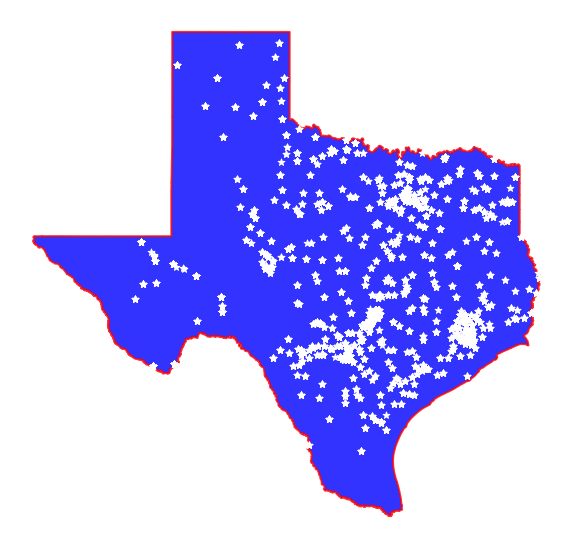

In [5]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=50, color="w", edgecolor="w")
ax.set_axis_off()

In [6]:
sites = sites[
    (sites.parm_cd == "00060")  # discharge
    & (sites.stat_cd == "00003")  # mean
    & (sites.count_nu >= 20 * 365)  # at least 20 years of data
    & ~sites.hcdn_2009  # not pristine
    & (sites.drain_sqkm > 10)
].copy()
sites.shape[0]

320

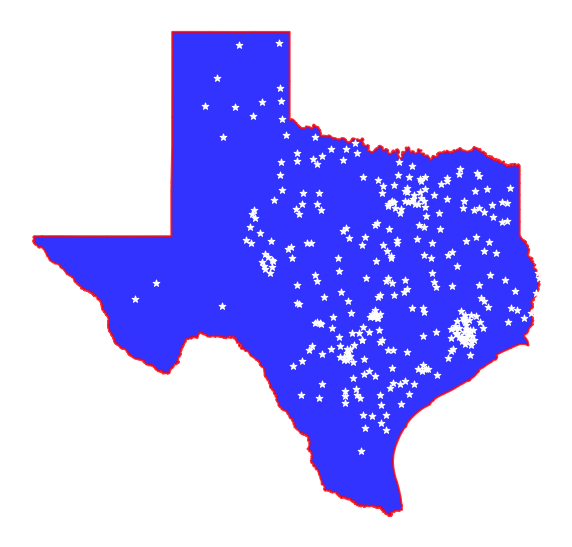

In [7]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=50, color="w", edgecolor="w")
ax.set_axis_off()

In [8]:
nid = NID()
nid.valid_fields[nid.valid_fields.str.contains("year", case=False)]

70      yearCompleted
71    yearCompletedId
83      yearsModified
Name: name, dtype: object

In [9]:
nid.valid_fields[nid.valid_fields.str.contains("state", case=False)]

13                stateFedId
17          stateRegulatedId
19     stateRegulatoryAgency
30                     state
31                 cityState
38               countyState
192                 statesId
194                 stateKey
Name: name, dtype: object

In [10]:
dam_list = nid.get_byfilter(
    [
        {
            "stateKey": ["TX"],
            "yearCompleted": ["[1995 2005]"],
        },
    ],
)
dams = dam_list[0]

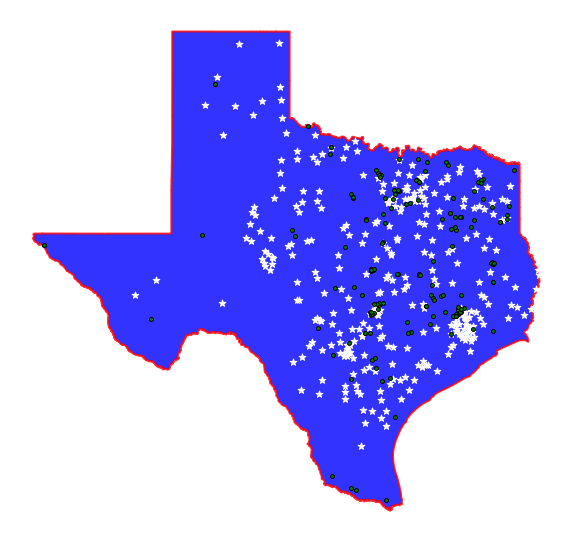

In [11]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=50, color="w", edgecolor="w")
dams.plot(ax=ax, marker="o", markersize=15, color="g", edgecolor="k")
ax.set_axis_off()

array([[<AxesSubplot:title={'center':'drain_sqkm'}>]], dtype=object)

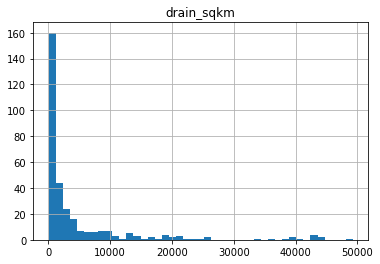

In [12]:
sites.hist("drain_sqkm", bins="auto")

In [13]:
def distance_filter(gdf1, gdf2, dist_km):
    """Filter gdf1 to only include points within distance of gdf2."""
    buff = gdf1.to_crs(5070).buffer(dist_km * 1e3)
    idx2, idx1 = buff.sindex.query_bulk(gdf2.to_crs(5070).geometry)
    return gdf1.iloc[pd.unique(idx1)].copy(), gdf2.iloc[pd.unique(idx2)].copy()

array([[<AxesSubplot:title={'center':'drain_sqkm'}>]], dtype=object)

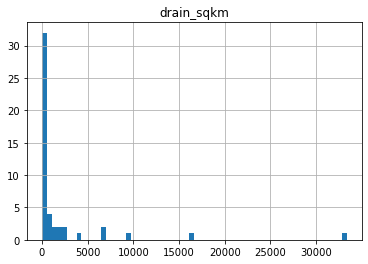

In [14]:
sites, dams = distance_filter(sites, dams, 10)
sites.hist("drain_sqkm", bins="auto")

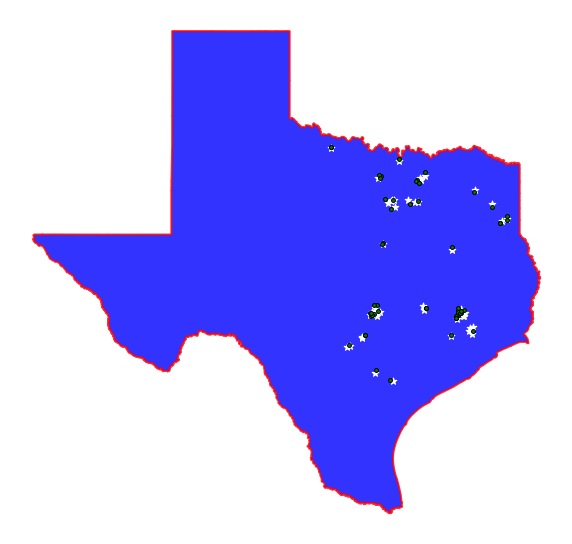

In [15]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=50, color="w", edgecolor="w")
dams.plot(ax=ax, marker="o", markersize=15, color="g", edgecolor="k")
ax.set_axis_off()

In [16]:
nldi = NLDI()

In [18]:
flw_up = {}
noflw = []
for agency, fid in sites[["agency_cd", "site_no"]].itertuples(index=False, name=None):
    try:
        flw_up[fid] = nldi.navigate_byid(
                fsource="nwissite",
                fid=f"{agency}-{fid}",
                navigation="upstreamMain",
                source="flowlines",
                distance=10,
            )
    except ZeroMatched:
        noflw.append(fid)

In [19]:
noflw

['08058900', '08059400']

In [22]:
sites = sites[sites.site_no.isin(flw_up)].copy()

In [26]:
sites, dams = distance_filter(sites, dams, 10)

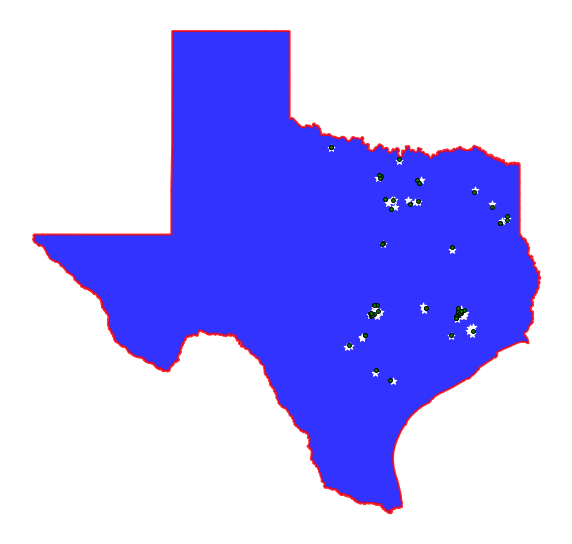

In [27]:
ax = texas.plot(facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=50, color="w", edgecolor="w")
dams.plot(ax=ax, marker="o", markersize=15, color="g", edgecolor="k")
ax.set_axis_off()

In [ ]:
meta = nldi.get_validchars("tot")
meta[meta.characteristic_description.str.contains("area", case=False)]

In [37]:
coords = list(dams[["longitude", "latitude"]].astype(float).itertuples(index=False, name=None))
nid_comids = nldi.comid_byloc(coords)

In [39]:
coords = list(sites[["dec_long_va", "dec_lat_va"]].astype(float).itertuples(index=False, name=None))
flw_comids = nldi.comid_byloc(coords)

In [42]:
dam_drainage = nldi.getcharacteristic_byid(nid_comids.comid.tolist(), "tot", "TOT_BASIN_AREA")
flw_drainage = nldi.getcharacteristic_byid(flw_comids.comid.tolist(), "tot", "TOT_BASIN_AREA")